In [38]:
import pandas as pd
import numpy as np
import requests
import zipfile
import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [3]:
# Step 1: Download and load the dataset
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
df = pd.read_csv(url)

In [4]:
# View the dataset
print("Preview of course_lead_scoring.csv (first 5 rows):")
print(df.head())
print("\nDataset Info:")
print(df.info())

Preview of course_lead_scoring.csv (first 5 rows):
    lead_source    industry  number_of_courses_viewed  annual_income  \
0      paid_ads         NaN                         1        79450.0   
1  social_media      retail                         1        46992.0   
2        events  healthcare                         5        78796.0   
3      paid_ads      retail                         2        83843.0   
4      referral   education                         3        85012.0   

  employment_status       location  interaction_count  lead_score  converted  
0        unemployed  south_america                  4        0.94          1  
1          employed  south_america                  1        0.80          0  
2        unemployed      australia                  3        0.69          1  
3               NaN      australia                  1        0.87          0  
4     self_employed         europe                  3        0.62          1  

Dataset Info:
<class 'pandas.core.frame.D

In [5]:
# Step 2: Standardize column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [18]:
# Step 3: Identify categorical and numerical features
# Based on typical lead scoring datasets, let's inspect columns
# Assume 'converted' is the target; adjust if different
#categorical = df.select_dtypes(include=['object']).columns.tolist()
#numerical = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 3: Define categorical and numerical features
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
target = 'converted'

In [7]:
# Exclude 'converted' from features if it's in numerical/categorical
if 'converted' in categorical:
    categorical.remove('converted')
if 'converted' in numerical:
    numerical.remove('converted')

In [19]:
# Verify target is binary
print("\nConverted value counts:")
print(df['converted'].value_counts())


Converted value counts:
converted
1    905
0    557
Name: count, dtype: int64


In [8]:
print("\nCategorical features:", categorical)
print("Numerical features:", numerical)


Categorical features: ['lead_source', 'industry', 'employment_status', 'location']
Numerical features: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']


In [9]:
# Step 4: Check for missing values
print("\nMissing values (NaN) per column:")
print(df.isnull().sum())
# Check for placeholders like 'unknown' or empty strings in categorical columns
print("\n'unknown' or empty string values in categorical columns:")
for col in categorical:
    unknown_count = (df[col] == 'unknown').sum()
    empty_count = (df[col] == '').sum()
    if unknown_count > 0 or empty_count > 0:
        print(f"{col}: unknown={unknown_count}, empty={empty_count}")


Missing values (NaN) per column:
lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

'unknown' or empty string values in categorical columns:


In [10]:
# Step 5: Handle missing values
# Categorical: Replace NaN, 'unknown', or empty strings with 'NA'
for col in categorical:
    df[col] = df[col].replace(['unknown', ''], 'NA').fillna('NA')

In [11]:
# Numerical: Replace NaN with 0.0
for col in numerical:
    df[col] = df[col].fillna(0.0)

In [12]:
# Verify no missing values remain
print("\nMissing values after replacement:")
print(df.isnull().sum())


Missing values after replacement:
lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


In [20]:
# Step 6: Convert target to binary (if not already)
# Assume 'converted' is the target; adjust if name differs (e.g., 'y' or 'subscribed')
#if 'converted' in df.columns:
#    df['converted'] = (df['converted'] == 1).astype(int)  # Ensure binary (0/1)
#else:
 #   print("Warning: 'converted' column not found. Please specify target column.")
    # Example: If target is 'y' or 'subscribed', adjust accordingly
    # df['converted'] = (df['y'] == 'yes').astype(int)


# Step 6: Ensure target is binary (already 0/1 based on preview)
df['converted'] = df['converted'].astype(int)    

In [21]:
# Step 7: Split the data (60/20/20)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [22]:
# Extract features and target
X_train = df_train[categorical + numerical]
y_train = df_train['converted'].values
X_val = df_val[categorical + numerical]
y_val = df_val['converted'].values
X_test = df_test[categorical + numerical]
y_test = df_test['converted'].values

In [23]:
# Step 8: Verify split sizes
total_rows = len(df)
print("\nDataset sizes:")
print(f"Total: {total_rows}")
print(f"Train: {len(X_train)} ({len(X_train)/total_rows:.2%})")
print(f"Validation: {len(X_val)} ({len(X_val)/total_rows:.2%})")
print(f"Test: {len(X_test)} ({len(X_test)/total_rows:.2%})")


Dataset sizes:
Total: 1462
Train: 876 (59.92%)
Validation: 293 (20.04%)
Test: 293 (20.04%)


In [24]:
# Step 9: Save splits to CSV for manual viewing
X_train.assign(converted=y_train).to_csv('lead_scoring_train.csv', index=False)
X_val.assign(converted=y_val).to_csv('lead_scoring_val.csv', index=False)
X_test.assign(converted=y_test).to_csv('lead_scoring_test.csv', index=False)
print("\nSaved splits to 'lead_scoring_train.csv', 'lead_scoring_val.csv', 'lead_scoring_test.csv' for manual viewing.")


Saved splits to 'lead_scoring_train.csv', 'lead_scoring_val.csv', 'lead_scoring_test.csv' for manual viewing.


In [29]:
# Step : Compute ROC AUC for each numerical variable
auc_scores = {}
for feature in numerical:
    # Use feature values as scores
    scores = X_train[feature].values
    
    # Compute AUC
    auc = roc_auc_score(y_train, scores)
    
    # If AUC < 0.5, invert the feature and recompute AUC
    if auc < 0.5:
        scores = -scores
        auc = roc_auc_score(y_train, scores)
        feature_name = f"-{feature}"
    else:
        feature_name = feature
    
    auc_scores[feature_name] = auc

# Step : Display AUC scores
print("ROC AUC scores for numerical variables:")
for feature, auc in auc_scores.items():
    print(f"{feature}: {auc:.4f}")

# Step : Identify the variable with the highest AUC
best_feature = max(auc_scores, key=auc_scores.get)
best_auc = auc_scores[best_feature]
print(f"\nNumerical variable with the highest AUC: {best_feature} (AUC = {best_auc:.4f})")

ROC AUC scores for numerical variables:
number_of_courses_viewed: 0.7636
annual_income: 0.5520
interaction_count: 0.7383
lead_score: 0.6145

Numerical variable with the highest AUC: number_of_courses_viewed (AUC = 0.7636)


In [32]:
# Step : Apply one-hot encoding with DictVectorizer
dv = DictVectorizer(sparse=False)
X_train_dv = dv.fit_transform(X_train.to_dict('records'))
X_val_dv = dv.transform(X_val.to_dict('records'))

# Step : Train the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_dv, y_train)

# Step : Predict probabilities on validation set
y_pred = model.predict_proba(X_val_dv)[:, 1]

# Step : Compute ROC AUC on validation set
auc = roc_auc_score(y_val, y_pred)
auc_rounded = round(auc, 3)

# Step : Display results
print(f"ROC AUC on validation set: {auc_rounded}")

# Compare to options
options = [0.32, 0.52, 0.72, 0.92]
print(f"Closest option: {min(options, key=lambda x: abs(x - auc_rounded))}")

ROC AUC on validation set: 0.817
Closest option: 0.72


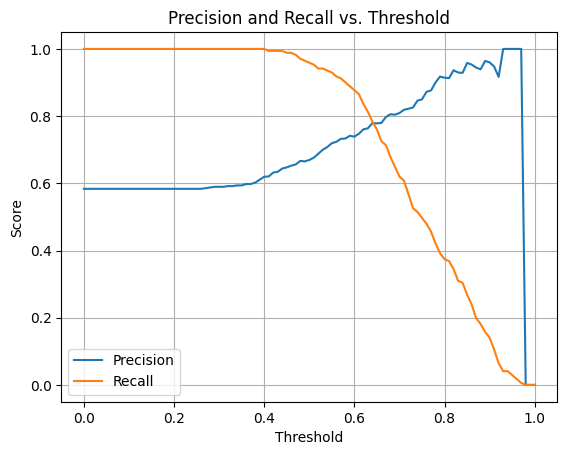


Intersection at threshold: 0.980
Precision at intersection: 0.000
Recall at intersection: 0.000
Closest option: 0.745


In [35]:
# Step : Compute precision and recall for thresholds
def precision_recall_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        scores.append((t, precision, recall))
    columns = ['threshold', 'precision', 'recall']
    df_scores = pd.DataFrame(scores, columns=columns)
    return df_scores

df_scores = precision_recall_dataframe(y_val, y_pred)

# Step : Plot precision and recall curves
plt.plot(df_scores['threshold'], df_scores['precision'], label='Precision')
plt.plot(df_scores['threshold'], df_scores['recall'], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Step : Find intersection point
df_scores['diff'] = np.abs(df_scores['precision'] - df_scores['recall'])
intersection_idx = df_scores['diff'].idxmin()
intersection_threshold = df_scores.loc[intersection_idx, 'threshold']
intersection_precision = df_scores.loc[intersection_idx, 'precision']
intersection_recall = df_scores.loc[intersection_idx, 'recall']

print(f"\nIntersection at threshold: {intersection_threshold:.3f}")
print(f"Precision at intersection: {intersection_precision:.3f}")
print(f"Recall at intersection: {intersection_recall:.3f}")

# Compare to options
options = [0.145, 0.345, 0.545, 0.745]
closest_option = min(options, key=lambda x: abs(x - intersection_threshold))
print(f"Closest option: {closest_option}")


Threshold with maximum F1 score: 0.570
Maximum F1 score: 0.812
Closest option: 0.54


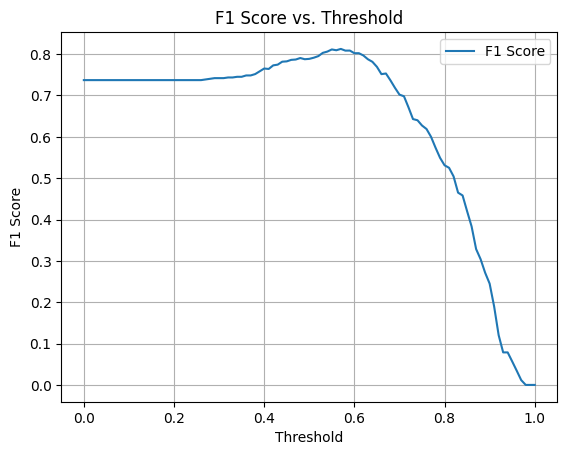

In [36]:
# Step : Compute precision, recall, and F1 for thresholds
def precision_recall_f1_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        scores.append((t, precision, recall, f1))
    columns = ['threshold', 'precision', 'recall', 'f1']
    df_scores = pd.DataFrame(scores, columns=columns)
    return df_scores

df_scores = precision_recall_f1_dataframe(y_val, y_pred)

# Step : Find threshold with maximum F1 score
max_f1_idx = df_scores['f1'].idxmax()
max_f1_threshold = df_scores.loc[max_f1_idx, 'threshold']
max_f1_score = df_scores.loc[max_f1_idx, 'f1']

print(f"\nThreshold with maximum F1 score: {max_f1_threshold:.3f}")
print(f"Maximum F1 score: {max_f1_score:.3f}")

# Compare to options
options = [0.14, 0.34, 0.54, 0.74]
closest_option = min(options, key=lambda x: abs(x - max_f1_threshold))
print(f"Closest option: {closest_option}")

# Step : Plot F1 score vs. threshold
plt.plot(df_scores['threshold'], df_scores['f1'], label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()



AUC scores for 5 folds: [0.8061, 0.8714, 0.7754, 0.8018, 0.8558]
Mean AUC: 0.8221
Standard deviation of AUC: 0.0358
Closest option: 0.06


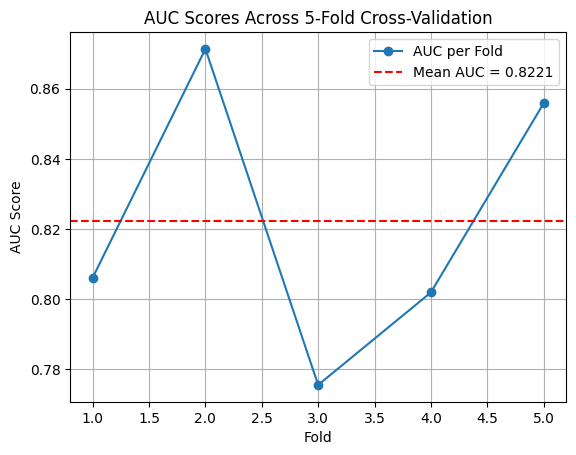

In [39]:
# Step : Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

# Step : Iterate over folds
for train_idx, val_idx in kf.split(df_full_train):
    # Split fold into train and validation
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    # Extract features and target
    X_train = df_train[categorical + numerical]
    y_train = df_train['converted'].values
    X_val = df_val[categorical + numerical]
    y_val = df_val['converted'].values
    
    # Apply one-hot encoding
    dv = DictVectorizer(sparse=False)
    X_train_dv = dv.fit_transform(X_train.to_dict('records'))
    X_val_dv = dv.transform(X_val.to_dict('records'))
    
    # Train the model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_dv, y_train)
    
    # Predict probabilities and compute AUC
    y_pred = model.predict_proba(X_val_dv)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

# Step : Compute standard deviation of AUC scores
auc_mean = np.mean(auc_scores)
auc_std = np.std(auc_scores)

print(f"AUC scores for 5 folds: {[round(auc, 4) for auc in auc_scores]}")
print(f"Mean AUC: {auc_mean:.4f}")
print(f"Standard deviation of AUC: {auc_std:.4f}")

# Compare to options
options = [0.0001, 0.006, 0.06, 0.36]
closest_option = min(options, key=lambda x: abs(x - auc_std))
print(f"Closest option: {closest_option}")

# Step : Plot AUC scores across folds
plt.plot(range(1, 6), auc_scores, marker='o', label='AUC per Fold')
plt.axhline(auc_mean, color='r', linestyle='--', label=f'Mean AUC = {auc_mean:.4f}')
plt.xlabel('Fold')
plt.ylabel('AUC Score')
plt.title('AUC Scores Across 5-Fold Cross-Validation')
plt.legend()
plt.grid(True)
plt.show()

5-Fold Cross-Validation Results:
C=1e-06: Mean AUC=0.56, Std AUC=0.024
C=0.001: Mean AUC=0.867, Std AUC=0.029
C=1: Mean AUC=0.822, Std AUC=0.036

Best C: 0.001 (Mean AUC=0.867, Std AUC=0.029)


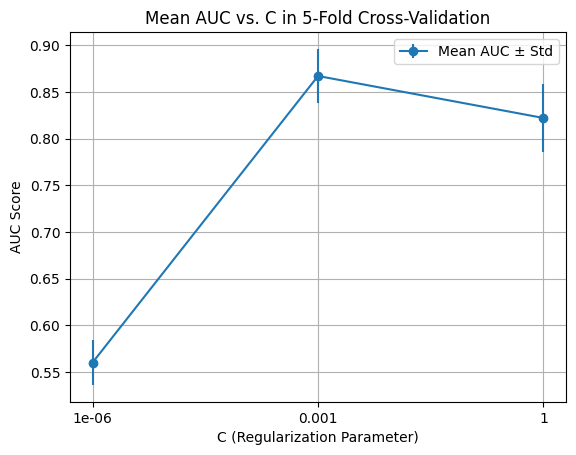

In [40]:
C_values = [0.000001, 0.001, 1]
results = []

#Step : Iterate over C values and folds
for C in C_values:
    auc_scores = []
    for train_idx, val_idx in kf.split(df_full_train):
        # Split fold into train and validation
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        # Extract features and target
        X_train = df_train[categorical + numerical]
        y_train = df_train['converted'].values
        X_val = df_val[categorical + numerical]
        y_val = df_val['converted'].values
        
        # Apply one-hot encoding
        dv = DictVectorizer(sparse=False)
        X_train_dv = dv.fit_transform(X_train.to_dict('records'))
        X_val_dv = dv.transform(X_val.to_dict('records'))
        
        # Train the model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_dv, y_train)
        
        # Predict probabilities and compute AUC
        y_pred = model.predict_proba(X_val_dv)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)
    
    # Compute mean and std of AUC scores
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    results.append({
        'C': C,
        'mean_auc': round(mean_auc, 3),
        'std_auc': round(std_auc, 3),
        'auc_scores': auc_scores
    })

# Step : Display results
print("5-Fold Cross-Validation Results:")
for result in results:
    print(f"C={result['C']}: Mean AUC={result['mean_auc']}, Std AUC={result['std_auc']}")

# Step : Select best C
best_result = max(results, key=lambda x: (x['mean_auc'], -x['std_auc'], -x['C']))
best_C = best_result['C']
print(f"\nBest C: {best_C} (Mean AUC={best_result['mean_auc']}, Std AUC={best_result['std_auc']})")

# Step : Plot mean AUC vs. C
C_labels = [str(C) for C in C_values]
mean_aucs = [result['mean_auc'] for result in results]
std_aucs = [result['std_auc'] for result in results]
plt.errorbar(C_labels, mean_aucs, yerr=std_aucs, fmt='o-', label='Mean AUC ± Std')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('AUC Score')
plt.title('Mean AUC vs. C in 5-Fold Cross-Validation')
plt.legend()
plt.grid(True)
plt.show()